In [3]:
%gui qt
%matplotlib qt
from glob import glob
import os, sys
# only necessary if using without installing
sys.path.append("..")
from xmcd_projection import *
from skimage.io import imread, imsave
from PIL import Image
import meshio
import trimesh

c:\users\lukas\miniconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\users\lukas\miniconda3\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
c:\users\lukas\miniconda3\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


### Get file paths

In [4]:
msh_file = "DW_MeshConv4nm_25nmSep.vtu"
mag_file = "DW_MeshConv4nm_25nmSep.csv"
# scale for the points
scale = 1e9

## Generate raytracing - skip if generated

In [6]:
# get the mesh, scale the points to nm
msh = Mesh.from_file(msh_file, scale=scale)

#### Make sure that the projection vector is correct and that the structure is oriented well

In [7]:
# get the projection vector
p = get_projection_vector(90, 0) # direction of xrays
n = [0, 1, 1] # normal to the projection plane
x0 = [-100, 0, 0] # point on the projection plane

# prepare raytracing object
raytr = RayTracing(msh, p, n=n, x0=x0)
struct = raytr.struct
struct_projected = raytr.struct_projected

In [8]:
vis = MeshVisualizer(struct, struct_projected)
vis.set_camera(dist=2e5)
vis.show()

## If raytracing file generated - skip if not

In [ ]:
# load raytracing if exists
raytr = np.load("raytracing.npy", allow_pickle=True).item()
struct = raytr.struct
struct_projected = raytr.struct_projected

## Generate and save raytracing

In [9]:
raytr.get_piercings()
# np.save("raytracing.npy", raytr, allow_pickle=True)

100%|███████████████████████████████████████████████████████████████████████████████| 56592/56592 [07:29<00:00, 125.99it/s]


## Get the xmcd

#### Get magnetisation, fix vertex shuffling
Note: sometimes if the mesh file has multiple parts, the paraview export and the original mesh coordinates are not in the same order. I add a function to fix that when necessary

In [10]:
magnetisation, mag_points = load_mesh_magnetisation(mag_file, scale=scale)
shuffle_file = "shuffle_indx.npy"
try:
    shuffle_indx = np.load(shuffle_file)
except FileNotFoundError:
    print('File not found. Generating shuffle indx')
    shuffle_indx = msh.get_shuffle_indx(mag_points)
    np.save(shuffle_file, shuffle_indx)
magnetisation = magnetisation[shuffle_indx, :]

File not found. Generating shuffle indx


In [ ]:
magnetisation, mag_points = load_mesh_magnetisation(mag_file, scale=scale)
shuffle_indx = msh.get_shuffle_indx(mag_points)
magnetisation = magnetisation[shuffle_indx, :]

### Get the colours and XMCD values

In [11]:
xmcd_value = raytr.get_xmcd(magnetisation)
mag_colors = get_struct_face_mag_color(struct, magnetisation)

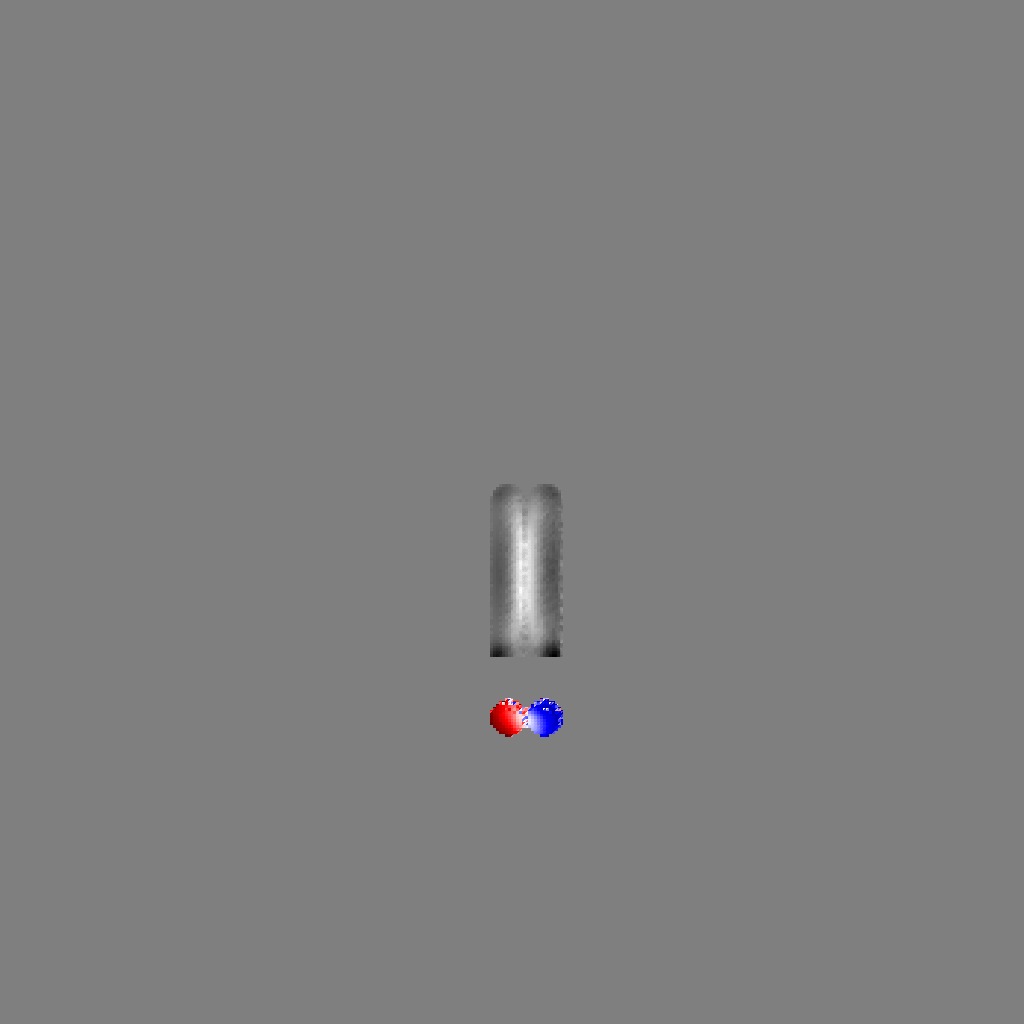

In [12]:
azi=90
center_struct = [0, 0, 0]
dist_struct = 1e4
center_peem = [100, -200, 0]
dist_peem = 8e4

vis = MeshVisualizer(struct, struct_projected, projected_xmcd=xmcd_value, struct_colors=mag_colors)
vis.show(azi=azi, center=center_peem, dist=dist_peem)
Image.fromarray(vis.get_image_np())

#### View different parts of the image separately

#### Both

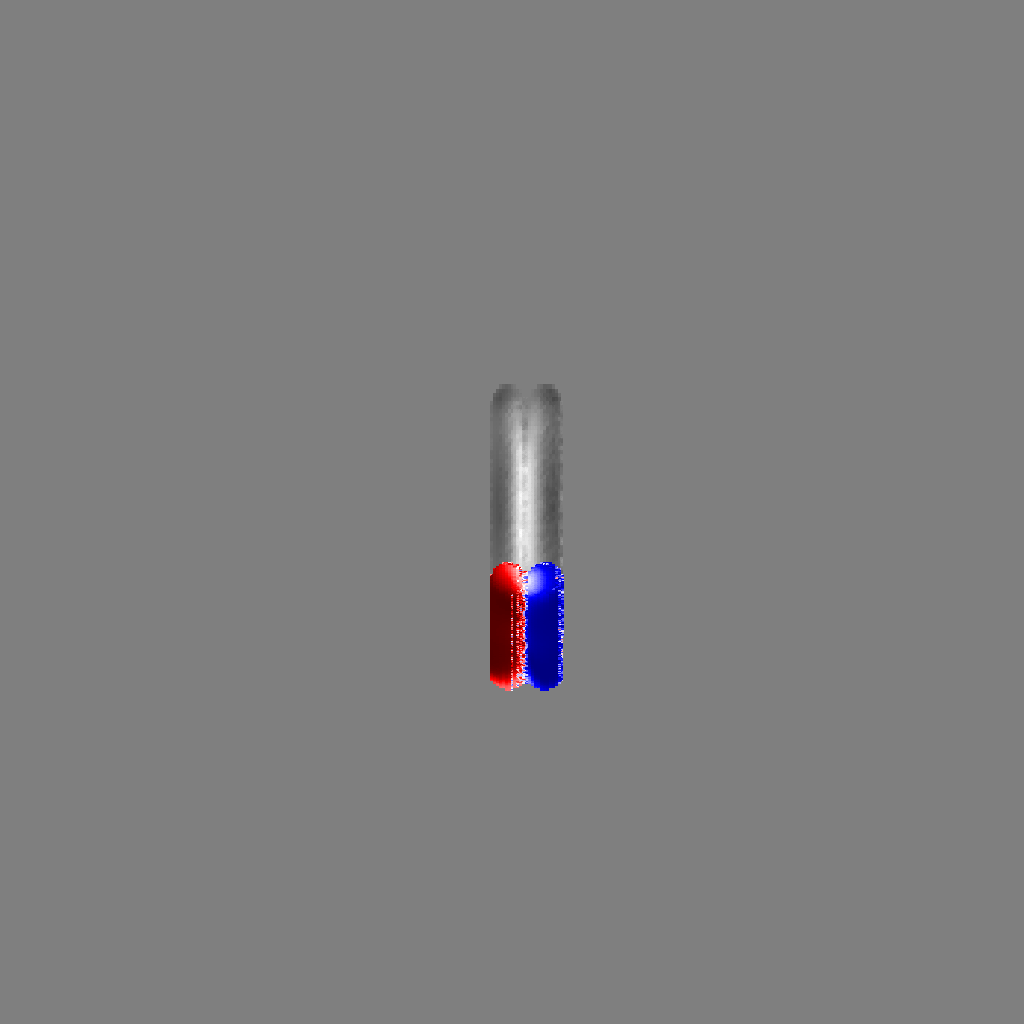

In [13]:

vis.update_colors(xmcd_value, mag_colors)
vis.view_both(azi=azi, center=center_peem, dist=dist_peem)
Image.fromarray(vis.get_image_np())

#### Projection

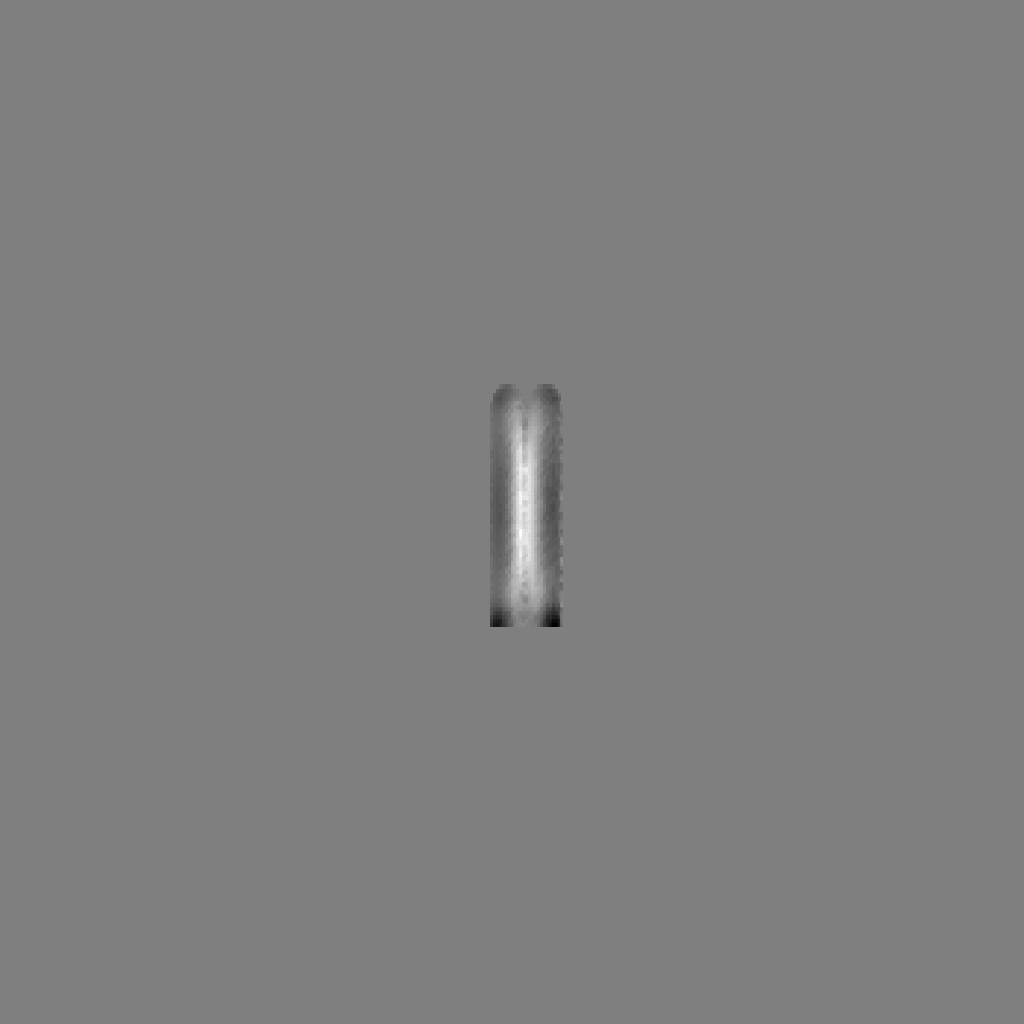

In [14]:
vis.view_projection(azi=azi, center=center_peem, dist=dist_peem)
Image.fromarray(vis.get_image_np())

#### Structure

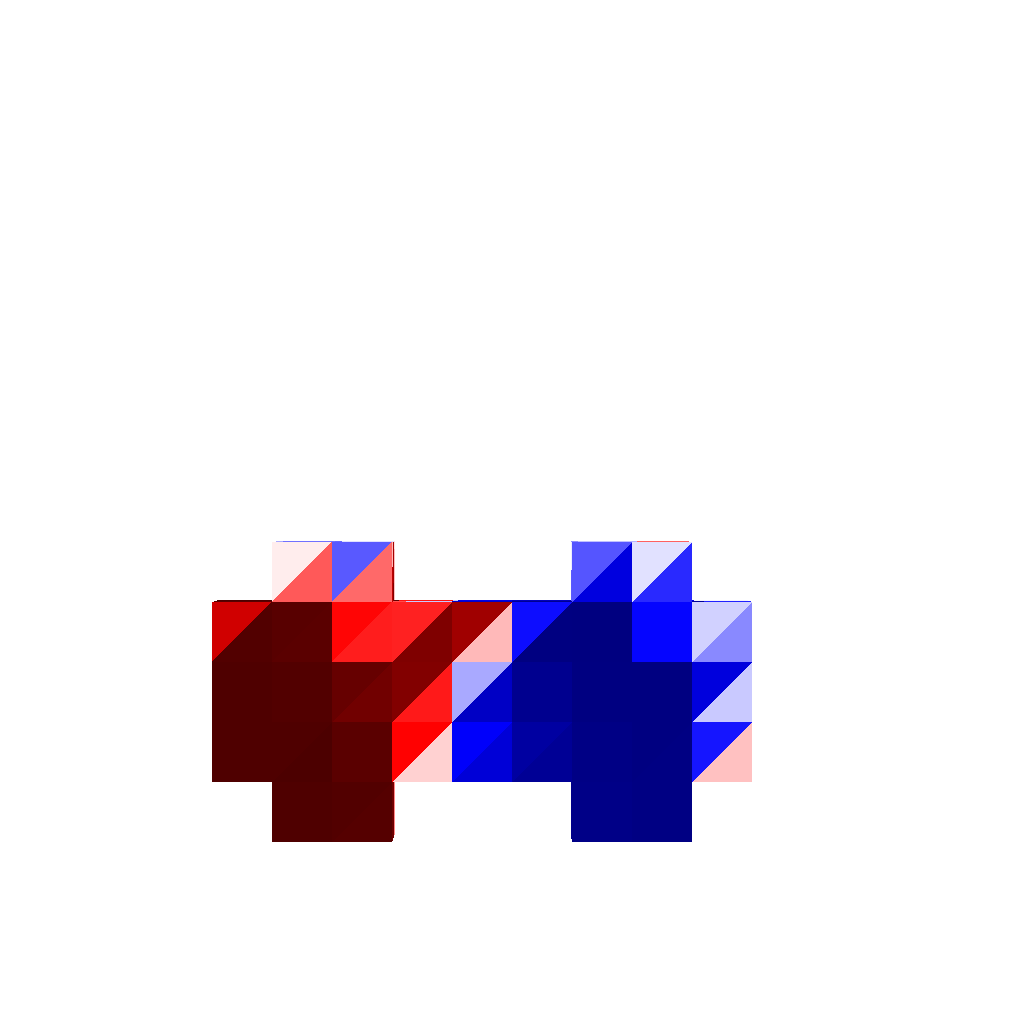

In [11]:

center_struct = [75, 50, 0]
dist_struct = 1e4
vis.view_struct(azi=azi, center=center_struct, dist=dist_struct)
Image.fromarray(vis.get_image_np())

#### Blurred image

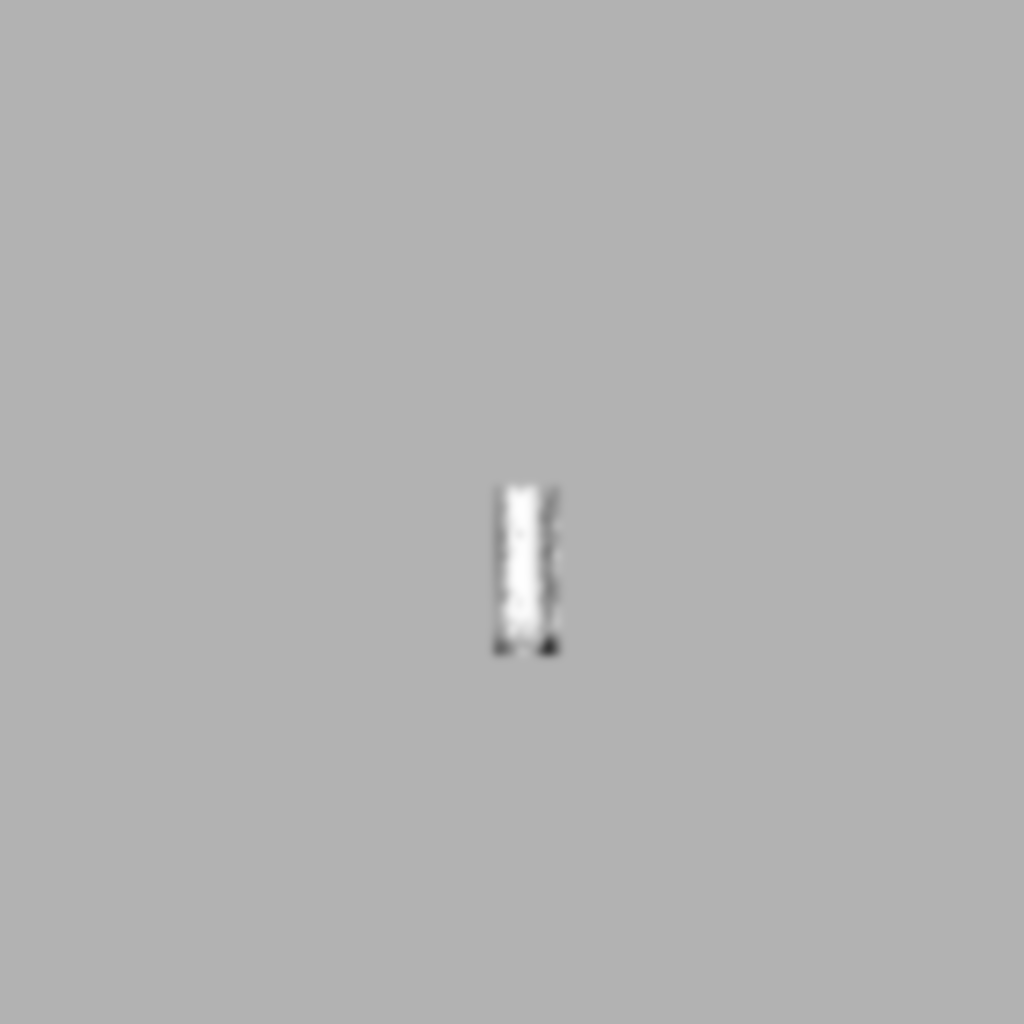

In [12]:
vis.view_projection(azi=azi, center=center_peem, dist=dist_peem)
Image.fromarray((vis.get_blurred_image(desired_background=0.7)*255).astype(np.uint8))

#### Saving one render

In [13]:
vis.view_both(azi=azi, center=center_peem, dist=dist_peem)
vis.save_render('mumax_shadow.png')
vis.view_projection()
blurred = vis.get_blurred_image(desired_background=0.7)
imsave('mumax_shadow_blurred.png', (blurred*255).astype(np.uint8), check_contrast=False)

vis.view_struct(azi=azi, center=center_struct, dist=dist_struct)
vis.save_render('mumax_structure_view.png')